# Pitcher D1 vs Non-D1 Baseline (Cleaned Data)

Baseline models using cleaned pitcher dataset. Includes a scaled Logistic Regression baseline and a CatBoost baseline.


In [179]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
from sklearn.impute import KNNImputer
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


In [180]:
data_path = r"/Users/ryankolodziejczyk/Documents/AI Baseball Recruitment/code/backend/data/pitchers/pitchers_data_clean.csv"
df = pd.read_csv(data_path)
print('shape', df.shape)
df.head()


shape (18343, 28)


,primary_position,height,weight,throwing_hand,FastballVelocity (max),FastballVelo Range,FastballSpin Rate (avg),Changeup Velo Range,Changeup Spin Rate (avg),Curveball Velo Range,...,fb_sl_velo_diff,FastballVelocity (max)_missing,FastballVelo Range_missing,FastballSpin Rate (avg)_missing,Changeup Velo Range_missing,Changeup Spin Rate (avg)_missing,Curveball Velo Range_missing,Curveball Spin Rate (avg)_missing,Slider Velo Range_missing,Slider Spin Rate (avg)_missing
0,RHP,74.0,225.0,R,91.0,89.5,2325.0,81.5,1787.0,77.0,...,NaN,0,0,0,0,0,0,0,1,1
1,RHP,76.0,180.0,R,87.0,84.5,2067.0,78.5,1661.0,76.5,...,NaN,0,0,0,0,0,0,0,1,1
2,LHP,70.0,160.0,L,81.0,80.0,2121.0,69.5,1670.0,65.4,...,NaN,0,0,0,0,0,0,0,1,1
3,RHP,75.0,195.0,R,85.8,83.0,2151.0,72.2,1719.0,66.8,...,16.4,0,0,0,0,0,0,0,0,0
4,RHP,71.0,170.0,R,90.0,87.3,2216.0,81.3,1952.0,75.0,...,16.8,0,0,0,0,0,0,0,0,1


## Feature inventory
Inspect available features after cleaning.

In [181]:
print(df.columns.tolist())
print('categorical', df.select_dtypes(include='object').columns.tolist())
print('numeric', df.select_dtypes(include='number').columns.tolist())


['primary_position', 'height', 'weight', 'throwing_hand', 'FastballVelocity (max)', 'FastballVelo Range', 'FastballSpin Rate (avg)', 'Changeup Velo Range', 'Changeup Spin Rate (avg)', 'Curveball Velo Range', 'Curveball Spin Rate (avg)', 'Slider Velo Range', 'Slider Spin Rate (avg)', 'Region', 'group', 'num_pitches', 'fb_ch_velo_diff', 'fb_cb_velo_diff', 'fb_sl_velo_diff', 'FastballVelocity (max)_missing', 'FastballVelo Range_missing', 'FastballSpin Rate (avg)_missing', 'Changeup Velo Range_missing', 'Changeup Spin Rate (avg)_missing', 'Curveball Velo Range_missing', 'Curveball Spin Rate (avg)_missing', 'Slider Velo Range_missing', 'Slider Spin Rate (avg)_missing']
categorical ['primary_position', 'throwing_hand', 'Region', 'group']
numeric ['height', 'weight', 'FastballVelocity (max)', 'FastballVelo Range', 'FastballSpin Rate (avg)', 'Changeup Velo Range', 'Changeup Spin Rate (avg)', 'Curveball Velo Range', 'Curveball Spin Rate (avg)', 'Slider Velo Range', 'Slider Spin Rate (avg)', 'nu

## Target mapping
D1 if group in {Power 4, Mid Major, Low Major}. Non-D1 otherwise.

In [182]:
d1_groups = {'Power 4', 'Mid Major', 'Low Major'}
df['d1_or_not'] = df['group'].isin(d1_groups).astype(int)
print(df['d1_or_not'].value_counts())


d1_or_not
0    11940
1     6403
Name: count, dtype: int64


## Feature set
Drop only the target column; all remaining pitcher attributes are used.

In [183]:
X = df.drop(columns=['group', 'd1_or_not', 'throwing_hand']) #throwing_hand is same as primary_position
y = df['d1_or_not']
print('features', X.shape)
X.head()


features (18343, 26)


,primary_position,height,weight,FastballVelocity (max),FastballVelo Range,FastballSpin Rate (avg),Changeup Velo Range,Changeup Spin Rate (avg),Curveball Velo Range,Curveball Spin Rate (avg),...,fb_sl_velo_diff,FastballVelocity (max)_missing,FastballVelo Range_missing,FastballSpin Rate (avg)_missing,Changeup Velo Range_missing,Changeup Spin Rate (avg)_missing,Curveball Velo Range_missing,Curveball Spin Rate (avg)_missing,Slider Velo Range_missing,Slider Spin Rate (avg)_missing
0,RHP,74.0,225.0,91.0,89.5,2325.0,81.5,1787.0,77.0,2240.0,...,NaN,0,0,0,0,0,0,0,1,1
1,RHP,76.0,180.0,87.0,84.5,2067.0,78.5,1661.0,76.5,2022.0,...,NaN,0,0,0,0,0,0,0,1,1
2,LHP,70.0,160.0,81.0,80.0,2121.0,69.5,1670.0,65.4,1942.0,...,NaN,0,0,0,0,0,0,0,1,1
3,RHP,75.0,195.0,85.8,83.0,2151.0,72.2,1719.0,66.8,1883.0,...,16.4,0,0,0,0,0,0,0,0,0
4,RHP,71.0,170.0,90.0,87.3,2216.0,81.3,1952.0,75.0,2360.0,...,16.8,0,0,0,0,0,0,0,0,1


## Train/test split

In [184]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print('train', X_train.shape, 'test', X_test.shape)


train (14674, 26) test (3669, 26)


## Baseline model (Scaled Logistic Regression, class_weight=balanced)

In [185]:
cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols),
    ]
)

clf = LogisticRegression(max_iter=5000, class_weight='balanced')

model = Pipeline(steps=[
    ('preprocess', preprocess),
    ('clf', clf)
])

model.fit(X_train, y_train)
pred = model.predict(X_test)
proba = model.predict_proba(X_test)[:, 1]

print('Accuracy:', accuracy_score(y_test, pred))
print('ROC-AUC:', roc_auc_score(y_test, proba))
print(classification_report(y_test, pred, digits=3))
print(confusion_matrix(y_test, pred))


Accuracy: 0.773235213954756
ROC-AUC: 0.8501980040718815
              precision    recall  f1-score   support

           0      0.871     0.765     0.814      2388
           1      0.643     0.789     0.708      1281

    accuracy                          0.773      3669
   macro avg      0.757     0.777     0.761      3669
weighted avg      0.791     0.773     0.777      3669

[[1826  562]
 [ 270 1011]]


## CatBoost baseline

In [186]:
from catboost import CatBoostClassifier

# CatBoost can handle categorical features directly
cat_features = [X.columns.get_loc(c) for c in cat_cols]

cb = CatBoostClassifier(
    iterations=500,
    depth=6,
    learning_rate=0.1,
    loss_function='Logloss',
    eval_metric='AUC',
    verbose=False,
    class_weights=[1.0, float(y_train.value_counts()[0]) / float(y_train.value_counts()[1])]
)

cb.fit(X_train, y_train, cat_features=cat_features)
cb_pred = cb.predict(X_test)
cb_proba = cb.predict_proba(X_test)[:, 1]

print('Accuracy:', accuracy_score(y_test, cb_pred))
print('ROC-AUC:', roc_auc_score(y_test, cb_proba))
print(classification_report(y_test, cb_pred, digits=3))
print(confusion_matrix(y_test, cb_pred))


Accuracy: 0.7686017988552739
ROC-AUC: 0.852330544212083
              precision    recall  f1-score   support

           0      0.861     0.768     0.812      2388
           1      0.640     0.769     0.699      1281

    accuracy                          0.769      3669
   macro avg      0.751     0.769     0.755      3669
weighted avg      0.784     0.769     0.773      3669

[[1835  553]
 [ 296  985]]


## CatBoost feature importance


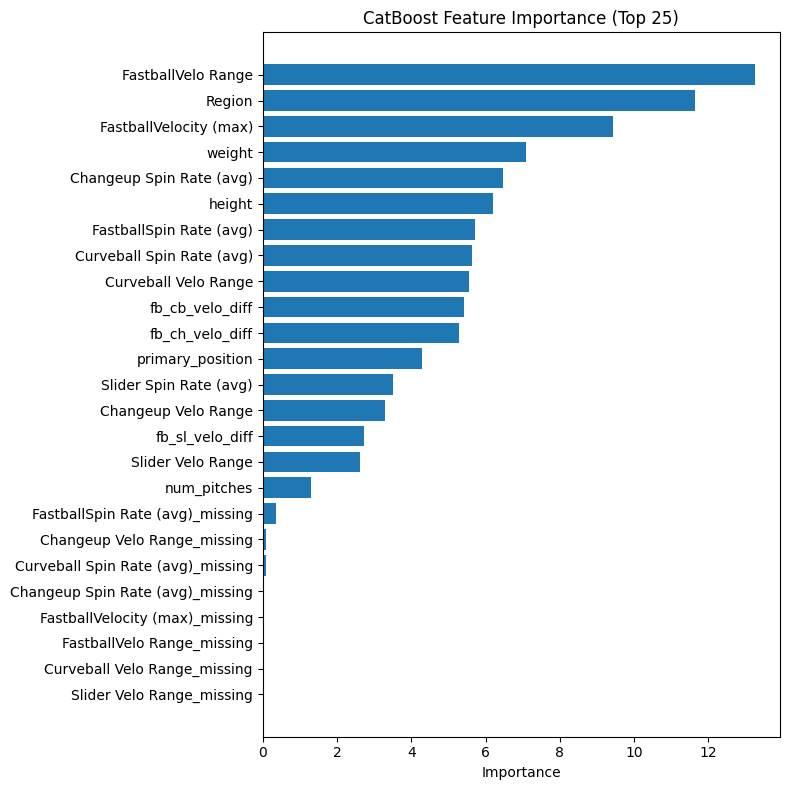

,feature,importance
4,FastballVelo Range,13.266331
12,Region,11.652115
3,FastballVelocity (max),9.429458
2,weight,7.076587
7,Changeup Spin Rate (avg),6.458967
1,height,6.198708
5,FastballSpin Rate (avg),5.719215
9,Curveball Spin Rate (avg),5.630906
8,Curveball Velo Range,5.556226
15,fb_cb_velo_diff,5.429727


In [187]:
# Feature importance (CatBoost)
importances = cb.get_feature_importance()
feat_names = X.columns.tolist()
fi = pd.DataFrame({'feature': feat_names, 'importance': importances})
fi = fi.sort_values('importance', ascending=False).head(25)

plt.figure(figsize=(8, 8))
plt.barh(fi['feature'][::-1], fi['importance'][::-1])
plt.title('CatBoost Feature Importance (Top 25)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

fi


## Missingness summary

In [188]:
missing = X.isna().mean().sort_values(ascending=False)
missing.head(15)


Slider Spin Rate (avg)          0.613695
fb_sl_velo_diff                 0.516055
Slider Velo Range               0.515837
Curveball Spin Rate (avg)       0.466554
Changeup Spin Rate (avg)        0.455487
FastballSpin Rate (avg)         0.354849
fb_ch_velo_diff                 0.251377
Changeup Velo Range             0.251104
FastballVelocity (max)          0.223955
fb_cb_velo_diff                 0.222374
Curveball Velo Range            0.221938
FastballVelo Range              0.140108
weight                          0.001963
height                          0.000218
Curveball Velo Range_missing    0.000000
dtype: float64

## Missing-flag ablation (with vs without *_missing features)

In [189]:
missing_flag_cols = [c for c in X.columns if c.endswith('_missing')]
print('missing flag cols:', missing_flag_cols)

X_train_nf = X_train.drop(columns=missing_flag_cols)
X_test_nf = X_test.drop(columns=missing_flag_cols)

cat_cols_nf = X_train_nf.select_dtypes(include='object').columns.tolist()
num_cols_nf = [c for c in X_train_nf.columns if c not in cat_cols_nf]

# Logistic Regression (no missing flags)
numeric_transformer_nf = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer_nf = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocess_nf = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_nf, num_cols_nf),
        ('cat', categorical_transformer_nf, cat_cols_nf),
    ]
)

clf_nf = LogisticRegression(max_iter=5000, class_weight='balanced')
model_nf = Pipeline(steps=[('preprocess', preprocess_nf), ('clf', clf_nf)])
model_nf.fit(X_train_nf, y_train)
pred_nf = model_nf.predict(X_test_nf)
proba_nf = model_nf.predict_proba(X_test_nf)[:, 1]

print('LogReg (no missing flags) Accuracy:', accuracy_score(y_test, pred_nf))
print('LogReg (no missing flags) ROC-AUC:', roc_auc_score(y_test, proba_nf))
print(classification_report(y_test, pred_nf, digits=3))
print(confusion_matrix(y_test, pred_nf))

# CatBoost (no missing flags)
cat_features_nf = [X_train_nf.columns.get_loc(c) for c in cat_cols_nf]
cb_nf = CatBoostClassifier(
    iterations=500,
    depth=6,
    learning_rate=0.1,
    loss_function='Logloss',
    eval_metric='AUC',
    verbose=False,
    class_weights=[1.0, float(y_train.value_counts()[0]) / float(y_train.value_counts()[1])]
)

cb_nf.fit(X_train_nf, y_train, cat_features=cat_features_nf)
cb_pred_nf = cb_nf.predict(X_test_nf)
cb_proba_nf = cb_nf.predict_proba(X_test_nf)[:, 1]

print('CatBoost (no missing flags) Accuracy:', accuracy_score(y_test, cb_pred_nf))
print('CatBoost (no missing flags) ROC-AUC:', roc_auc_score(y_test, cb_proba_nf))
print(classification_report(y_test, cb_pred_nf, digits=3))
print(confusion_matrix(y_test, cb_pred_nf))


missing flag cols: ['FastballVelocity (max)_missing', 'FastballVelo Range_missing', 'FastballSpin Rate (avg)_missing', 'Changeup Velo Range_missing', 'Changeup Spin Rate (avg)_missing', 'Curveball Velo Range_missing', 'Curveball Spin Rate (avg)_missing', 'Slider Velo Range_missing', 'Slider Spin Rate (avg)_missing']
LogReg (no missing flags) Accuracy: 0.76151539929136
LogReg (no missing flags) ROC-AUC: 0.8407450013533712
              precision    recall  f1-score   support

           0      0.863     0.753     0.804      2388
           1      0.628     0.778     0.695      1281

    accuracy                          0.762      3669
   macro avg      0.746     0.765     0.750      3669
weighted avg      0.781     0.762     0.766      3669

[[1798  590]
 [ 285  996]]
CatBoost (no missing flags) Accuracy: 0.7653311529026983
CatBoost (no missing flags) ROC-AUC: 0.8529967689082938
              precision    recall  f1-score   support

           0      0.855     0.770     0.810      2388

Based on the results, we should keep the missingness flags.

## Feature engineering (v2)
Guided by EDA: emphasize velocity strength, secondary pitch quality, and size/handedness effects.


In [190]:
# Create a new FE dataset to preserve prior baselines
df_fe2 = df.copy()

# Base columns
fb_max = df_fe2['FastballVelocity (max)']
fb_range = df_fe2['FastballVelo Range']
fb_spin = df_fe2['FastballSpin Rate (avg)']

ch_velo = df_fe2['Changeup Velo Range']
cb_velo = df_fe2['Curveball Velo Range']
sl_velo = df_fe2['Slider Velo Range']

ch_spin = df_fe2['Changeup Spin Rate (avg)']
cb_spin = df_fe2['Curveball Spin Rate (avg)']
sl_spin = df_fe2['Slider Spin Rate (avg)']

# Availability counts (repertoire depth)
df_fe2['num_velo_available'] = df_fe2[['FastballVelo Range','Changeup Velo Range','Curveball Velo Range','Slider Velo Range']].notna().sum(axis=1)
df_fe2['num_spin_available'] = df_fe2[['FastballSpin Rate (avg)','Changeup Spin Rate (avg)','Curveball Spin Rate (avg)','Slider Spin Rate (avg)']].notna().sum(axis=1)

# Secondary pitch aggregates (velocity and spin)
df_fe2['secondary_velo_mean'] = pd.concat([ch_velo, cb_velo, sl_velo], axis=1).mean(axis=1)
df_fe2['secondary_velo_max'] = pd.concat([ch_velo, cb_velo, sl_velo], axis=1).max(axis=1)
df_fe2['secondary_velo_min'] = pd.concat([ch_velo, cb_velo, sl_velo], axis=1).min(axis=1)

df_fe2['secondary_spin_mean'] = pd.concat([ch_spin, cb_spin, sl_spin], axis=1).mean(axis=1)
df_fe2['secondary_spin_max'] = pd.concat([ch_spin, cb_spin, sl_spin], axis=1).max(axis=1)

# Fastball strength proxies (EDA: strongest signal)
df_fe2['fb_strength'] = (fb_max + fb_range) / 2
df_fe2['fb_spin_per_mph'] = fb_spin / fb_max

# Gaps between fastball and secondary pitches
df_fe2['fb_to_best_secondary_gap'] = fb_range - df_fe2['secondary_velo_max']
df_fe2['fb_to_avg_secondary_gap'] = fb_range - df_fe2['secondary_velo_mean']

# Spin efficiency for secondaries
df_fe2['secondary_spin_per_mph'] = df_fe2['secondary_spin_mean'] / df_fe2['secondary_velo_mean']
df_fe2['fb_spin_minus_secondary_spin'] = fb_spin - df_fe2['secondary_spin_mean']

# Velocity spread (overall pitch mix)
df_fe2['velo_spread_all'] = pd.concat([fb_range, df_fe2['secondary_velo_max']], axis=1).max(axis=1) - pd.concat([fb_range, df_fe2['secondary_velo_min']], axis=1).min(axis=1)

# Presence flags for key secondaries (slider presence had signal in missingness)
df_fe2['has_slider'] = sl_velo.notna().astype(int)
df_fe2['has_changeup'] = ch_velo.notna().astype(int)
df_fe2['has_curveball'] = cb_velo.notna().astype(int)

# Size and size-adjusted velocity
df_fe2['bmi_like'] = (df_fe2['weight'] / (df_fe2['height'] ** 2)) * 703
df_fe2['fb_max_per_height'] = fb_max / df_fe2['height']
df_fe2['fb_max_per_weight'] = fb_max / df_fe2['weight']

df_fe2[[
    'fb_strength','secondary_velo_max','fb_to_best_secondary_gap',
    'secondary_spin_per_mph','velo_spread_all','has_slider',
    'bmi_like','fb_max_per_height'
]].head()


,fb_strength,secondary_velo_max,fb_to_best_secondary_gap,secondary_spin_per_mph,velo_spread_all,has_slider,bmi_like,fb_max_per_height
0,90.25,81.5,8.0,25.406940,12.5,0,28.885135,1.229730
1,85.75,78.5,6.0,23.761290,8.0,0,21.907895,1.144737
2,80.50,69.5,10.5,26.775389,14.6,0,22.955102,1.157143
3,84.40,72.2,10.8,26.595331,16.4,1,24.370667,1.144000
4,88.65,81.3,6.0,28.518519,16.8,1,23.707598,1.267606


### FE v2: Feature selection + models


In [191]:
X_fe2 = df_fe2.drop(columns=['group', 'd1_or_not'])
y_fe2 = df_fe2['d1_or_not']

X_train_fe2, X_test_fe2, y_train_fe2, y_test_fe2 = train_test_split(
    X_fe2, y_fe2, test_size=0.2, random_state=42, stratify=y_fe2
)

cat_cols_fe2 = X_train_fe2.select_dtypes(include='object').columns.tolist()
num_cols_fe2 = [c for c in X_train_fe2.columns if c not in cat_cols_fe2]

numeric_transformer_fe2 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer_fe2 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocess_fe2 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_fe2, num_cols_fe2),
        ('cat', categorical_transformer_fe2, cat_cols_fe2),
    ]
)

clf_fe2 = LogisticRegression(max_iter=5000, class_weight='balanced')
model_fe2 = Pipeline(steps=[('preprocess', preprocess_fe2), ('clf', clf_fe2)])

model_fe2.fit(X_train_fe2, y_train_fe2)
pred_fe2 = model_fe2.predict(X_test_fe2)
proba_fe2 = model_fe2.predict_proba(X_test_fe2)[:, 1]

print('LogReg FEv2 Accuracy:', accuracy_score(y_test_fe2, pred_fe2))
print('LogReg FEv2 ROC-AUC:', roc_auc_score(y_test_fe2, proba_fe2))
print(classification_report(y_test_fe2, pred_fe2, digits=3))
print(confusion_matrix(y_test_fe2, pred_fe2))

# CatBoost FEv2
cat_features_fe2 = [X_train_fe2.columns.get_loc(c) for c in cat_cols_fe2]
cb_fe2 = CatBoostClassifier(
    iterations=500,
    depth=6,
    learning_rate=0.1,
    loss_function='Logloss',
    eval_metric='AUC',
    verbose=False,
    class_weights=[1.0, float(y_train_fe2.value_counts()[0]) / float(y_train_fe2.value_counts()[1])]
)

cb_fe2.fit(X_train_fe2, y_train_fe2, cat_features=cat_features_fe2)
cb_pred_fe2 = cb_fe2.predict(X_test_fe2)
cb_proba_fe2 = cb_fe2.predict_proba(X_test_fe2)[:, 1]

print('CatBoost FEv2 Accuracy:', accuracy_score(y_test_fe2, cb_pred_fe2))
print('CatBoost FEv2 ROC-AUC:', roc_auc_score(y_test_fe2, cb_proba_fe2))
print(classification_report(y_test_fe2, cb_pred_fe2, digits=3))
print(confusion_matrix(y_test_fe2, cb_pred_fe2))


LogReg FEv2 Accuracy: 0.7691469065140365
LogReg FEv2 ROC-AUC: 0.8512182627945871
              precision    recall  f1-score   support

           0      0.868     0.761     0.811      2388
           1      0.638     0.785     0.704      1281

    accuracy                          0.769      3669
   macro avg      0.753     0.773     0.757      3669
weighted avg      0.788     0.769     0.773      3669

[[1817  571]
 [ 276 1005]]
CatBoost FEv2 Accuracy: 0.7634232760970292
CatBoost FEv2 ROC-AUC: 0.8501839473192137
              precision    recall  f1-score   support

           0      0.855     0.766     0.808      2388
           1      0.635     0.759     0.691      1281

    accuracy                          0.763      3669
   macro avg      0.745     0.762     0.750      3669
weighted avg      0.778     0.763     0.767      3669

[[1829  559]
 [ 309  972]]


## LightGBM baseline
Gradient boosting baseline with categorical one-hot encoding.


In [192]:
# LightGBM baseline using FE v2 features (X_fe2)
cat_cols_lgb = X_train.select_dtypes(include='object').columns.tolist()
num_cols_lgb = [c for c in X_train.columns if c not in cat_cols_lgb]

numeric_transformer_lgb = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_transformer_lgb = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocess_lgb = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_lgb, num_cols_lgb),
        ('cat', categorical_transformer_lgb, cat_cols_lgb),
    ]
)

lgbm = lgb.LGBMClassifier(
    n_estimators=400,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight='balanced',
    random_state=42
)

lgb_model = Pipeline(steps=[
    ('preprocess', preprocess_lgb),
    ('clf', lgbm)
])

lgb_model.fit(X_train, y_train)
lgb_pred = lgb_model.predict(X_test)
lgb_proba = lgb_model.predict_proba(X_test)[:, 1]

print('Accuracy:', accuracy_score(y_test, lgb_pred))
print('ROC-AUC:', roc_auc_score(y_test, lgb_proba))
print(classification_report(y_test, lgb_pred, digits=3))
print(confusion_matrix(y_test, lgb_pred))


[LightGBM] [Info] Number of positive: 5122, number of negative: 9552
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2962
[LightGBM] [Info] Number of data points in the train set: 14674, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Accuracy: 0.7688743526846552
ROC-AUC: 0.8503356294875365
              precision    recall  f1-score   support

           0      0.865     0.765     0.812      2388
           1      0.639     0.777     0.701      1281

    accuracy                          0.769      3669
   macro avg      0.752     0.771     0.756      3669
weighted avg      0.786     0.769     0.773      3669

[[1826  562]
 [ 286  995]]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## XGBoost baseline (normal features)
Uses the original feature set (no FE v2).


In [193]:
# XGBoost baseline using original features (X_train/X_test)
cat_cols_xgb = X_train.select_dtypes(include='object').columns.tolist()
num_cols_xgb = [c for c in X_train.columns if c not in cat_cols_xgb]

numeric_transformer_xgb = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_transformer_xgb = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocess_xgb = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_xgb, num_cols_xgb),
        ('cat', categorical_transformer_xgb, cat_cols_xgb),
    ]
)

scale_pos_weight = float(y_train.value_counts()[0]) / float(y_train.value_counts()[1])
xgb_clf = xgb.XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric='auc',
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

xgb_model = Pipeline(steps=[
    ('preprocess', preprocess_xgb),
    ('clf', xgb_clf)
])

xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_proba = xgb_model.predict_proba(X_test)[:, 1]

print('Accuracy:', accuracy_score(y_test, xgb_pred))
print('ROC-AUC:', roc_auc_score(y_test, xgb_proba))
print(classification_report(y_test, xgb_pred, digits=3))
print(confusion_matrix(y_test, xgb_pred))


Accuracy: 0.76778413736713
ROC-AUC: 0.8535619811260309
              precision    recall  f1-score   support

           0      0.861     0.768     0.811      2388
           1      0.639     0.768     0.698      1281

    accuracy                          0.768      3669
   macro avg      0.750     0.768     0.755      3669
weighted avg      0.783     0.768     0.772      3669

[[1833  555]
 [ 297  984]]


## Baseline LogReg did the best, now with KNN imputer instead of median

In [194]:
cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('imputer', KNNImputer(n_neighbors=10))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols),
    ]
)

clf = LogisticRegression(max_iter=5000, class_weight='balanced')

model_logreg_knnimp = Pipeline(steps=[
    ('preprocess', preprocess),
    ('clf', clf)
])

model_logreg_knnimp.fit(X_train, y_train)
pred = model_logreg_knnimp.predict(X_test)
proba = model_logreg_knnimp.predict_proba(X_test)[:, 1]

print('Accuracy:', accuracy_score(y_test, pred))
print('ROC-AUC:', roc_auc_score(y_test, proba))
print(classification_report(y_test, pred, digits=3))
print(confusion_matrix(y_test, pred))


Accuracy: 0.7718724448078496
ROC-AUC: 0.854374657570967
              precision    recall  f1-score   support

           0      0.876     0.756     0.812      2388
           1      0.638     0.801     0.710      1281

    accuracy                          0.772      3669
   macro avg      0.757     0.779     0.761      3669
weighted avg      0.793     0.772     0.776      3669

[[1806  582]
 [ 255 1026]]


## CV threshold tuning (LogReg)
Find cutoff that maximizes F1 using K-fold CV on predicted probabilities.


In [195]:
# K-fold CV to pick threshold: maximize precision with guardrails
cat_cols_cv = X.select_dtypes(include='object').columns.tolist()
num_cols_cv = [c for c in X.columns if c not in cat_cols_cv]

numeric_transformer_cv = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=10)),
    ('scaler', StandardScaler())
])

categorical_transformer_cv = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocess_cv = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_cv, num_cols_cv),
        ('cat', categorical_transformer_cv, cat_cols_cv),
    ]
)

clf_cv = LogisticRegression(max_iter=5000, class_weight='balanced')
model_cv = Pipeline(steps=[
    ('preprocess', preprocess_cv),
    ('clf', clf_cv)
])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
proba_cv = cross_val_predict(model_cv, X, y, cv=skf, method='predict_proba')[:, 1]

thresholds = np.linspace(0.4, 0.75, 81)
rows = []
for t in thresholds:
    preds = (proba_cv >= t).astype(int)
    rows.append({
        'threshold': t,
        'accuracy': accuracy_score(y, preds),
        'precision': precision_score(y, preds, zero_division=0),
        'recall': recall_score(y, preds),
        'f1': f1_score(y, preds)
    })

results = pd.DataFrame(rows)

# Guardrails: use class-1 (D1) recall >= 0.70 and accuracy >= 0.75 (tweak as needed)
guarded = results[(results['accuracy'] >= 0.75) & (results['recall'] >= 0.70)]
if len(guarded) == 0:
    print('No thresholds met guardrails. Showing top precision overall.')
    best = results.sort_values(['precision','f1'], ascending=False).head(10)
else:
    best = guarded.sort_values(['precision','f1'], ascending=False).head(10)

print('Top thresholds by precision (with guardrails if available):')
display(best)

best_row = best.iloc[0]
print('Selected threshold:', best_row['threshold'])
print('Accuracy:', best_row['accuracy'])
print('Precision:', best_row['precision'])
print('Recall:', best_row['recall'])
print('F1:', best_row['f1'])


Top thresholds by precision (with guardrails if available):


,threshold,accuracy,precision,recall,f1
39,0.570625,0.767868,0.656821,0.701546,0.678447
38,0.566250,0.767486,0.654614,0.706856,0.679733
37,0.561875,0.767159,0.652547,0.712166,0.681054
36,0.557500,0.765742,0.648981,0.716383,0.681018
35,0.553125,0.765687,0.647595,0.721224,0.682429
34,0.548750,0.764815,0.644848,0.726222,0.683120
33,0.544375,0.764161,0.642749,0.730283,0.683726
32,0.540000,0.763070,0.639799,0.735124,0.684157
31,0.535625,0.762089,0.636938,0.740590,0.684864
30,0.531250,0.761653,0.635130,0.745432,0.685874


Selected threshold: 0.5706249999999999
Accuracy: 0.7678678514964836
Precision: 0.6568211726860652
Recall: 0.701546150242074
F1: 0.6784473644464583


## Apply CV-selected threshold on test set


In [196]:

# using same prior LogReg model, but with a threshold we found
proba_thr = model_logreg_knnimp.predict_proba(X_test)[:, 1]
pred_thr = (proba_thr >= best_row['threshold']).astype(int)

print('Accuracy:', accuracy_score(y_test, pred_thr))
print('ROC-AUC:', roc_auc_score(y_test, proba_thr))
print(classification_report(y_test, pred_thr, digits=3))
print(confusion_matrix(y_test, pred_thr))


Accuracy: 0.7789588443717634
ROC-AUC: 0.854374657570967
              precision    recall  f1-score   support

           0      0.841     0.814     0.827      2388
           1      0.673     0.713     0.692      1281

    accuracy                          0.779      3669
   macro avg      0.757     0.764     0.760      3669
weighted avg      0.782     0.779     0.780      3669

[[1945  443]
 [ 368  913]]


## Grouped KNN imputation (by primary_position) + LogReg


In [197]:
# Grouped KNN imputer: fit/transform separately for each primary_position
X_g = X.copy()
y_g = y.copy()

# Train/test split
X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(
    X_g, y_g, test_size=0.2, random_state=42, stratify=y_g
)

def fit_predict_grouped_knn(X_train, X_test, y_train, y_test, group_col='primary_position'):
    preds_all = []
    probas_all = []
    idx_all = []

    for grp in sorted(X_train[group_col].unique()):
        # subset
        train_idx = X_train[X_train[group_col] == grp].index
        test_idx = X_test[X_test[group_col] == grp].index

        X_tr = X_train.loc[train_idx]
        X_te = X_test.loc[test_idx]
        y_tr = y_train.loc[train_idx]
        y_te = y_test.loc[test_idx]

        # preprocess + model
        cat_cols_g = X_tr.select_dtypes(include='object').columns.tolist()
        num_cols_g = [c for c in X_tr.columns if c not in cat_cols_g]

        numeric_transformer_g = Pipeline(steps=[
            ('imputer', KNNImputer(n_neighbors=10)),
            ('scaler', StandardScaler())
        ])

        categorical_transformer_g = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])

        preprocess_g = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer_g, num_cols_g),
                ('cat', categorical_transformer_g, cat_cols_g),
            ]
        )

        clf_g = LogisticRegression(max_iter=5000, class_weight='balanced')
        model_g = Pipeline(steps=[
            ('preprocess', preprocess_g),
            ('clf', clf_g)
        ])

        model_g.fit(X_tr, y_tr)
        proba = model_g.predict_proba(X_te)[:, 1]
        pred = (proba >= best_row['threshold']).astype(int)        

        preds_all.append(pd.Series(pred, index=test_idx))
        probas_all.append(pd.Series(proba, index=test_idx))
        idx_all.extend(test_idx)

    preds_all = pd.concat(preds_all).loc[X_test.index]
    probas_all = pd.concat(probas_all).loc[X_test.index]
    return preds_all.values, probas_all.values

pred_g, proba_g = fit_predict_grouped_knn(X_train_g, X_test_g, y_train_g, y_test_g)

print('Accuracy:', accuracy_score(y_test_g, pred_g))
print('ROC-AUC:', roc_auc_score(y_test_g, proba_g))
print(classification_report(y_test_g, pred_g, digits=3))
print(confusion_matrix(y_test_g, pred_g))


Accuracy: 0.779503952030526
ROC-AUC: 0.853041554376096
              precision    recall  f1-score   support

           0      0.839     0.819     0.829      2388
           1      0.676     0.706     0.691      1281

    accuracy                          0.780      3669
   macro avg      0.758     0.763     0.760      3669
weighted avg      0.782     0.780     0.781      3669

[[1955  433]
 [ 376  905]]


## Grouped KNN CV threshold tuning (by primary_position)


In [198]:
# CV threshold tuning for grouped KNN (primary_position)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

skf_g = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

proba_cv_all = []
y_cv_all = []

for train_idx, test_idx in skf_g.split(X, y):
    X_train_g = X.iloc[train_idx]
    X_test_g = X.iloc[test_idx]
    y_train_g = y.iloc[train_idx]
    y_test_g = y.iloc[test_idx]

    preds_all = []
    probas_all = []

    for grp in sorted(X_train_g['primary_position'].unique()):
        train_idx_grp = X_train_g[X_train_g['primary_position'] == grp].index
        test_idx_grp = X_test_g[X_test_g['primary_position'] == grp].index

        X_tr = X_train_g.loc[train_idx_grp]
        X_te = X_test_g.loc[test_idx_grp]
        y_tr = y_train_g.loc[train_idx_grp]
        y_te = y_test_g.loc[test_idx_grp]

        cat_cols_g = X_tr.select_dtypes(include='object').columns.tolist()
        num_cols_g = [c for c in X_tr.columns if c not in cat_cols_g]

        numeric_transformer_g = Pipeline(steps=[
            ('imputer', KNNImputer(n_neighbors=10)),
            ('scaler', StandardScaler())
        ])

        categorical_transformer_g = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])

        preprocess_g = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer_g, num_cols_g),
                ('cat', categorical_transformer_g, cat_cols_g),
            ]
        )

        clf_g = LogisticRegression(max_iter=5000, class_weight='balanced')
        model_g = Pipeline(steps=[
            ('preprocess', preprocess_g),
            ('clf', clf_g)
        ])

        model_g.fit(X_tr, y_tr)
        proba = model_g.predict_proba(X_te)[:, 1]

        probas_all.append(pd.Series(proba, index=test_idx_grp))

    probas_all = pd.concat(probas_all).loc[X_test_g.index]
    proba_cv_all.append(probas_all)
    y_cv_all.append(y_test_g)

proba_cv = pd.concat(proba_cv_all).sort_index()
y_cv = pd.concat(y_cv_all).sort_index()

thresholds = np.linspace(0.35, 0.75, 81)
rows = []
for t in thresholds:
    preds = (proba_cv >= t).astype(int)
    rows.append({
        'threshold': t,
        'accuracy': accuracy_score(y_cv, preds),
        'precision': precision_score(y_cv, preds, zero_division=0),
        'recall': recall_score(y_cv, preds),
        'f1': f1_score(y_cv, preds)
    })

results_g = pd.DataFrame(rows)
guarded_g = results_g[(results_g['accuracy'] >= 0.76) & (results_g['recall'] >= 0.72)]
if len(guarded_g) == 0:
    print('No thresholds met guardrails. Showing top precision overall.')
    best_g = results_g.sort_values(['precision','f1'], ascending=False).head(10)
else:
    best_g = guarded_g.sort_values(['precision','f1'], ascending=False).head(10)

print('Top thresholds by precision (grouped KNN):')
display(best_g)

best_row_g = best_g.iloc[0]
print('Selected threshold:', best_row_g['threshold'])
print('Accuracy:', best_row_g['accuracy'])
print('Precision:', best_row_g['precision'])
print('Recall:', best_row_g['recall'])
print('F1:', best_row_g['f1'])

# Apply grouped KNN model with CV-selected threshold
pred_g_best, proba_g_best = fit_predict_grouped_knn(X_train_g, X_test_g, y_train_g, y_test_g)
pred_thr = (proba_g_best >= best_row_g['threshold']).astype(int)

print('Accuracy:', accuracy_score(y_test_g, pred_thr))
print('ROC-AUC:', roc_auc_score(y_test_g, proba_g_best))
print(classification_report(y_test_g, pred_thr, digits=3))
print(confusion_matrix(y_test_g, pred_thr))

Top thresholds by precision (grouped KNN):


,threshold,accuracy,precision,recall,f1
39,0.545,0.763725,0.643860,0.723099,0.681183
38,0.540,0.763179,0.641240,0.729970,0.682734
37,0.535,0.762471,0.638995,0.734499,0.683427
36,0.530,0.760999,0.635122,0.741059,0.684013
35,0.525,0.760835,0.633439,0.747306,0.685677


Selected threshold: 0.5449999999999999
Accuracy: 0.7637245815842556
Precision: 0.6438603810318454
Recall: 0.7230985475558332
F1: 0.6811828747977049
Accuracy: 0.7625408942202835
ROC-AUC: 0.8420077274392799
              precision    recall  f1-score   support

           0      0.841     0.783     0.811      2388
           1      0.642     0.724     0.680      1280

    accuracy                          0.763      3668
   macro avg      0.741     0.754     0.746      3668
weighted avg      0.772     0.763     0.765      3668

[[1870  518]
 [ 353  927]]


## Model selection & save
We select the non-grouped LogReg + KNN imputer model because it matches or exceeds more complex models while staying simple and interpretable. This reduces maintenance risk and keeps feature effects understandable.


In [199]:
import os
import json as _json
import joblib
from datetime import datetime

# Ensure model_logreg_knnimp is trained before saving
version_tag = datetime.now().strftime('version_%m%d%Y')
model_dir = f'/Users/ryankolodziejczyk/Documents/AI Baseball Recruitment/code/backend/ml/models/models_p/models_d1_or_not_p/{version_tag}'
os.makedirs(model_dir, exist_ok=True)

model_path = os.path.join(model_dir, 'logreg_knn_model.pkl')
metadata_path = os.path.join(model_dir, 'model_metadata.json')

joblib.dump(model_logreg_knnimp, model_path)

metadata = {
    'model_type': 'LogisticRegression',
    'imputer': 'KNNImputer(n_neighbors=10)',
    'scaler': 'StandardScaler',
    'threshold': float(best_row['threshold']),
    'features': list(X.columns),
    'notes': 'Selected for simplicity + strong performance vs complex models',
}

with open(metadata_path, 'w') as f:
    _json.dump(metadata, f, indent=2)

print('Saved model to:', model_path)
print('Saved metadata to:', metadata_path)


Saved model to: /Users/ryankolodziejczyk/Documents/AI Baseball Recruitment/code/backend/ml/models/models_p/models_d1_or_not_p/version_01302026/logreg_knn_model.pkl
Saved metadata to: /Users/ryankolodziejczyk/Documents/AI Baseball Recruitment/code/backend/ml/models/models_p/models_d1_or_not_p/version_01302026/model_metadata.json
